In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [2]:
# RMSLE Metric Function
def rmsle(y_true, y_pred):
    y_true = np.maximum(0, y_true)
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

# Custom Dataset Split Function
def split_dataset(dataset, test_ratio=0.30, random_seed=42):
  np.random.seed(random_seed)
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [3]:
# Load Data 
print("--- Loading Data ---")
try:
    train_df = pd.read_csv('/kaggle/input/house-prediction-a/house-prices-advanced-regression-techniques/train.csv')
    test_df = pd.read_csv('/kaggle/input/house-prediction-a/house-prices-advanced-regression-techniques/test.csv')
    sample_submission_df = pd.read_csv('/kaggle/input/house-prediction-a/house-prices-advanced-regression-techniques/sample_submission.csv')

    try:
        with open('data_description.txt', 'r') as f:
            data_description = f.read()
    except FileNotFoundError:
        print("Warning: data_description.txt not found in current directory. Please ensure its path is correct if you wish to read it.")
        data_description = "Description not loaded." 

    print("Files loaded successfully!")
    print(f"train_df initial shape: {train_df.shape}")
    print(f"test_df initial shape: {test_df.shape}")
    print("\n--- First 5 columns of train_df (head) ---")
    print(train_df.iloc[:, :5].head())
    print("\n--- All columns in train_df ---")
    print(train_df.columns.tolist())
    print("\n--- All columns in test_df ---")
    print(test_df.columns.tolist())


except Exception as e: 
    print(f"Error loading files: {e}")
    print("Please double-check the file paths on Kaggle and ensure they are correct.")
    exit()

--- Loading Data ---
Files loaded successfully!
train_df initial shape: (1460, 81)
test_df initial shape: (1459, 80)

--- First 5 columns of train_df (head) ---
   Id  MSSubClass MSZoning  LotFrontage  LotArea
0   1          60       RL         65.0     8450
1   2          20       RL         80.0     9600
2   3          60       RL         68.0    11250
3   4          70       RL         60.0     9550
4   5          60       RL         84.0    14260

--- All columns in train_df ---
['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'To

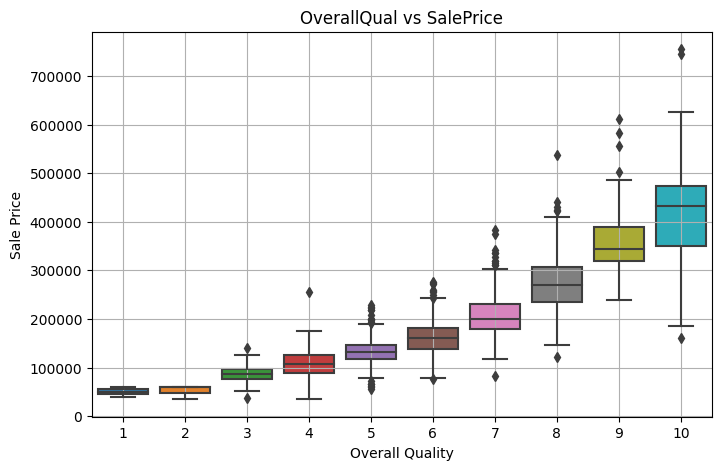

In [4]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df)
plt.title('OverallQual vs SalePrice')
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
plt.grid(True)
plt.show()

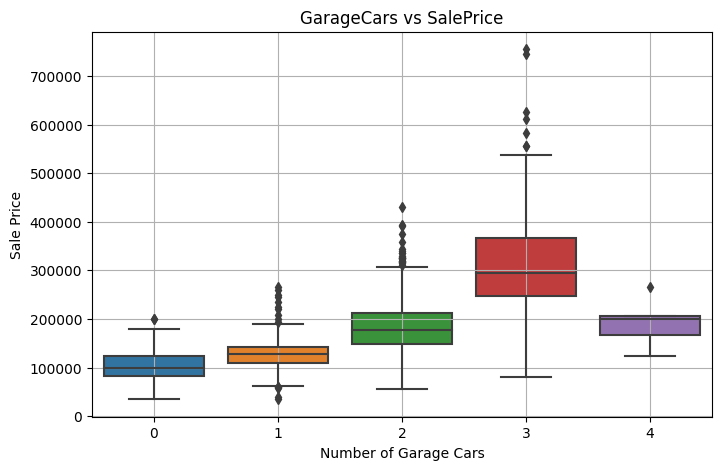

In [5]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='GarageCars', y='SalePrice', data=train_df)
plt.title('GarageCars vs SalePrice')
plt.xlabel('Number of Garage Cars')
plt.ylabel('Sale Price')
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


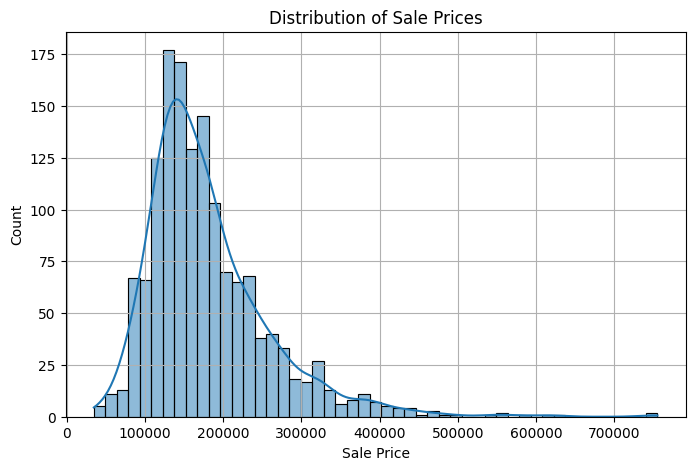

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.grid(True)
plt.show()

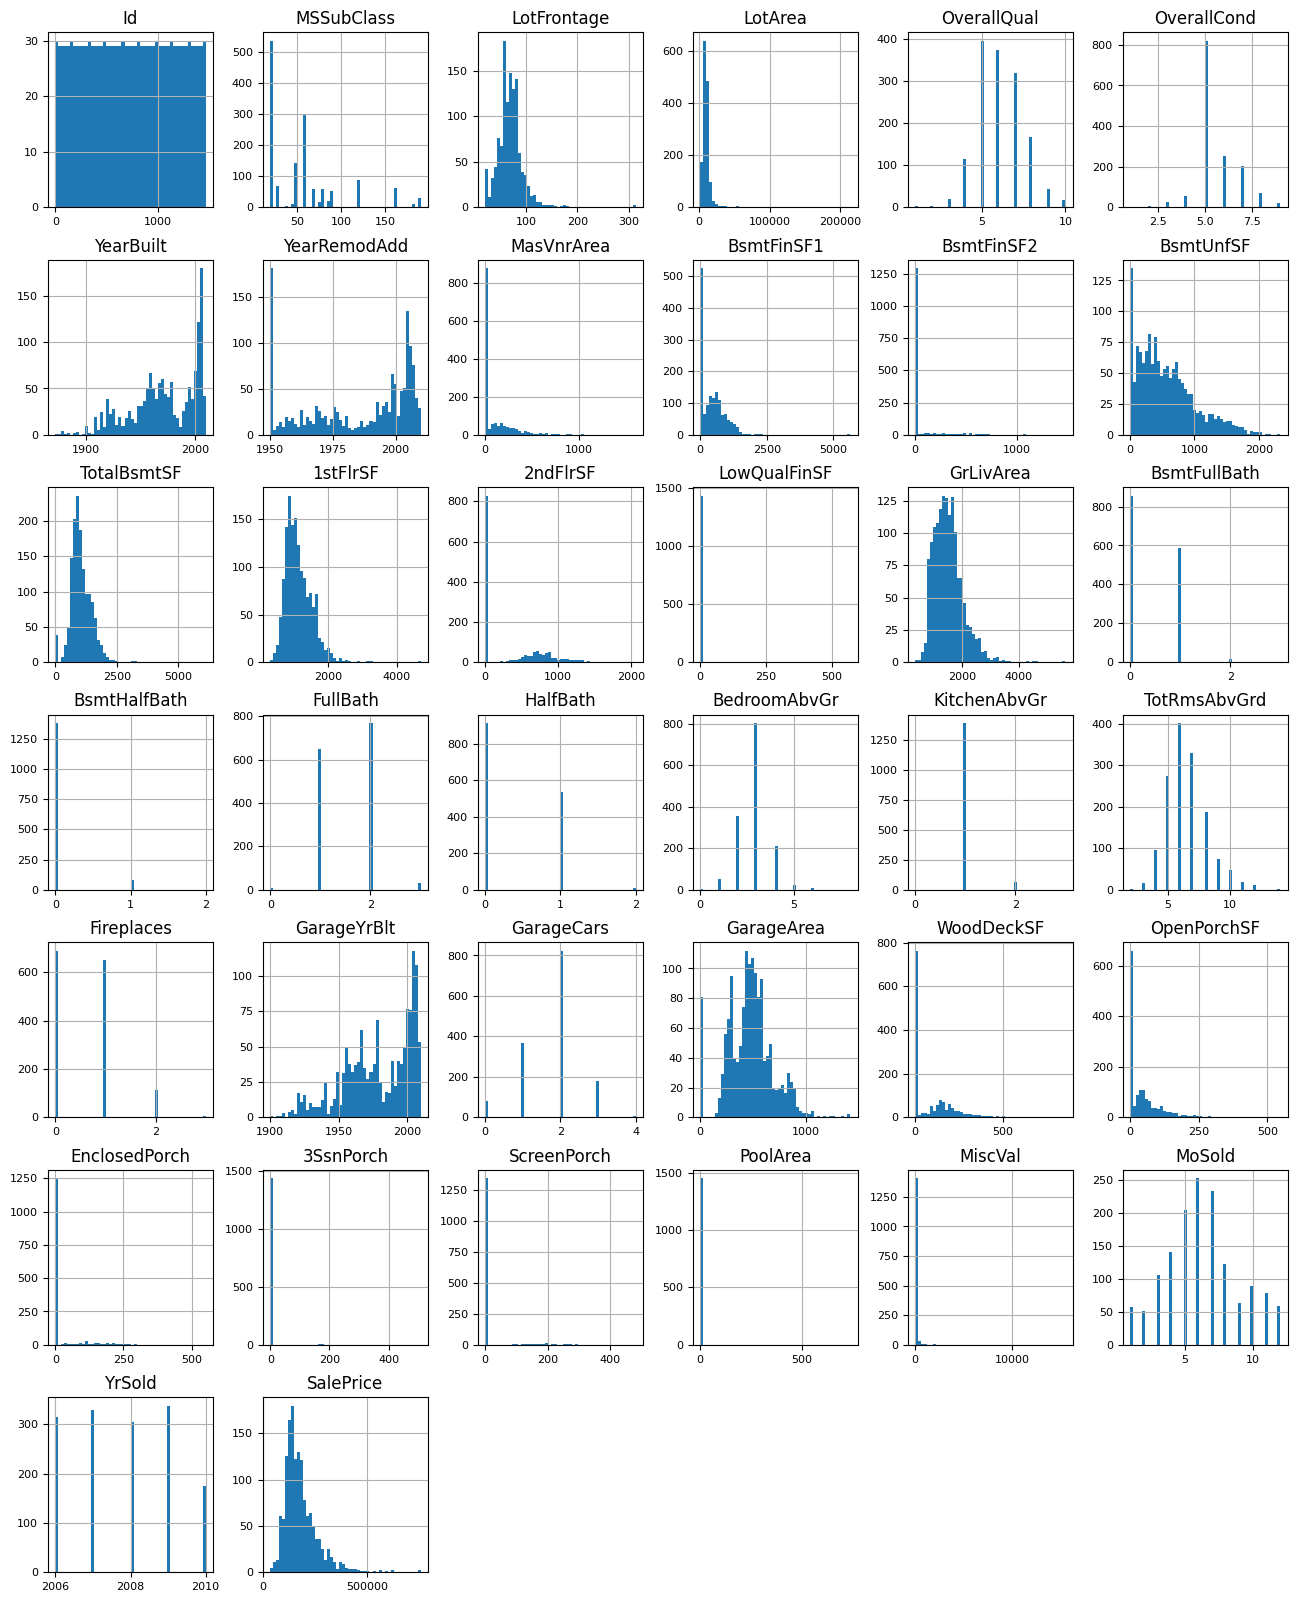

In [7]:
train_df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [8]:
COL_GR_LIV_AREA = 'GrLivArea'
COL_BEDROOMS_ABOVE_GR = 'BedroomAbvGr'
COL_FULL_BATH = 'FullBath'
COL_HALF_BATH = 'HalfBath'
COL_BSMT_FULL_BATH = 'BsmtFullBath'
COL_BSMT_HALF_BATH = 'BsmtHalfBath'
COL_TOTAL_BSMT_SF = 'TotalBsmtSF'
COL_1ST_FLR_SF = '1stFlrSF'
COL_2ND_FLR_SF = '2ND_FLR_SF' 
COL_GARAGE_AREA = 'GarageArea'
COL_SALE_PRICE = 'SalePrice'
COL_ID = 'Id'
REQUIRED_FE_COLS = [
    COL_GR_LIV_AREA, COL_BEDROOMS_ABOVE_GR, COL_FULL_BATH,
    COL_HALF_BATH, COL_BSMT_FULL_BATH, COL_BSMT_HALF_BATH,
    COL_TOTAL_BSMT_SF, COL_GARAGE_AREA, COL_SALE_PRICE
]

In [9]:
# Feature Engineering & Selection
print("\n--- Feature Engineering ---")

def engineer_features(df, is_train_set=True):
    df_copy = df.copy()


    for col in REQUIRED_FE_COLS: 
        if col not in df_copy.columns:
            if is_train_set and col == COL_SALE_PRICE: 
                continue
            df_copy[col] = 0
            print(f"Warning: Column '{col}' not found in DataFrame. Added with default 0s.")

    df_copy['TotalSF'] = df_copy[COL_GR_LIV_AREA] + \
                          df_copy[COL_TOTAL_BSMT_SF] + \
                          df_copy[COL_GARAGE_AREA] 

    df_copy['TotalBath'] = df_copy[COL_FULL_BATH] + \
                            0.5 * df_copy[COL_HALF_BATH] + \
                            df_copy[COL_BSMT_FULL_BATH] + \
                            0.5 * df_copy[COL_BSMT_HALF_BATH] 

    return df_copy

train_df_fe = engineer_features(train_df, is_train_set=True)
test_df_fe = engineer_features(test_df, is_train_set=False)
MODEL_FEATURES = ['TotalSF', COL_BEDROOMS_ABOVE_GR, 'TotalBath'] 
print(f"Engineered features created. Using {MODEL_FEATURES} for the model.")
print(f"train_df_fe shape: {train_df_fe.shape}")
print(f"test_df_fe shape: {test_df_fe.shape}")


--- Feature Engineering ---
Engineered features created. Using ['TotalSF', 'BedroomAbvGr', 'TotalBath'] for the model.
train_df_fe shape: (1460, 83)
test_df_fe shape: (1459, 83)


In [10]:
# Data Cleaning and Preprocessing
print("\n--- Data Cleaning and Preprocessing ---")

# Outlier Handling

initial_rows_train = train_df_fe.shape[0]
train_df_cleaned = train_df_fe[train_df_fe[COL_GR_LIV_AREA] < 4000].copy() 
print(f"Removed {initial_rows_train - train_df_cleaned.shape[0]} potential outlier rows from training data based on {COL_GR_LIV_AREA} < 4000.")

if train_df_cleaned.empty:
    print("CRITICAL ERROR: No training data remaining after outlier removal! Adjust the threshold or remove this step.")
    exit() 

test_ids = test_df_fe[COL_ID]
test_df_processed = test_df_fe.copy() 

# Handle missing values for the selected model features in both train and test sets

for col in MODEL_FEATURES:
    train_df_cleaned[col] = pd.to_numeric(train_df_cleaned[col], errors='coerce')
    test_df_processed[col] = pd.to_numeric(test_df_processed[col], errors='coerce')


imputer = SimpleImputer(strategy='median')
train_df_cleaned[MODEL_FEATURES] = imputer.fit_transform(train_df_cleaned[MODEL_FEATURES])
print("Missing values in training MODEL_FEATURES imputed.")

test_df_processed[MODEL_FEATURES] = imputer.transform(test_df_processed[MODEL_FEATURES])
print("Missing values in test MODEL_FEATURES imputed.")

print("\n--- Final NaN check in MODEL_FEATURES ---")
if train_df_cleaned[MODEL_FEATURES].isnull().any().any():
    print("ERROR: NaNs still present in training MODEL_FEATURES after imputation!")
    print(train_df_cleaned[MODEL_FEATURES].isnull().sum())
if test_df_processed[MODEL_FEATURES].isnull().any().any():
    print("ERROR: NaNs still present in test MODEL_FEATURES after imputation!")
    print(test_df_processed[MODEL_FEATURES].isnull().sum())

print(f"train_df_cleaned final shape: {train_df_cleaned.shape}")
print(f"test_df_processed final shape: {test_df_processed.shape}")


# Target Variable Transformation

train_df_cleaned[COL_SALE_PRICE] = np.log1p(train_df_cleaned[COL_SALE_PRICE])
print(f"{COL_SALE_PRICE} in training data has been log1p transformed.")

# Define X and y for training
X = train_df_cleaned[MODEL_FEATURES]
y = train_df_cleaned[COL_SALE_PRICE] 


--- Data Cleaning and Preprocessing ---
Removed 4 potential outlier rows from training data based on GrLivArea < 4000.
Missing values in training MODEL_FEATURES imputed.
Missing values in test MODEL_FEATURES imputed.

--- Final NaN check in MODEL_FEATURES ---
train_df_cleaned final shape: (1456, 83)
test_df_processed final shape: (1459, 83)
SalePrice in training data has been log1p transformed.


In [11]:
# Data Splitting and Scaling
print("\n--- Splitting Data and Scaling Features ---")
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and validation sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert scaled arrays back to DataFrames for easier column management (optional, but good for tracking)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=MODEL_FEATURES, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=MODEL_FEATURES, index=X_val.index)

# Prepare test data for prediction by scaling it using the SAME scaler fitted on training data
X_test_scaled = scaler.transform(test_df_processed[MODEL_FEATURES])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=MODEL_FEATURES, index=test_df_processed.index)
print(f"X_test_scaled_df shape: {X_test_scaled_df.shape}")


--- Splitting Data and Scaling Features ---
X_train shape: (1164, 3), y_train shape: (1164,)
X_val shape: (292, 3), y_val shape: (292,)
X_test_scaled_df shape: (1459, 3)


In [12]:
# Model Building and Training
print("\n--- Training Linear Regression Model ---")
model = LinearRegression()
model.fit(X_train_scaled_df, y_train)


--- Training Linear Regression Model ---


LinearRegression()

In [13]:
# Model Evaluation
print("\n--- Model Evaluation Metrics ---")

y_pred_val_log = model.predict(X_val_scaled_df)

y_pred_val_original = np.expm1(y_pred_val_log)
y_val_original = np.expm1(y_val)

# Loss Metrics
mae = mean_absolute_error(y_val_original, y_pred_val_original)
print(f"Loss (Mean Absolute Error - MAE) on validation set (original scale): ${mae:,.2f}")

mse = mean_squared_error(y_val_original, y_pred_val_original)
rmse = np.sqrt(mse)
print(f"Loss (Root Mean Squared Error - RMSE) on validation set (original scale): ${rmse:,.2f}")


--- Model Evaluation Metrics ---
Loss (Mean Absolute Error - MAE) on validation set (original scale): $26,215.49
Loss (Root Mean Squared Error - RMSE) on validation set (original scale): $36,718.85


In [14]:
# Accuracy Metrics
r2 = r2_score(y_val_original, y_pred_val_original)
print(f"Accuracy (R-squared - R2) on validation set (original scale): {r2:.4f}")

rmsle_score = rmsle(y_val_original, y_pred_val_original)
print(f"Kaggle Accuracy (Root Mean Squared Logarithmic Error - RMSLE) on validation set: {rmsle_score:.4f}")

print("\n--- Model Coefficients and Intercept (on scaled features) ---")
for i, feature in enumerate(MODEL_FEATURES):
    print(f"  {feature}: {model.coef_[i]:.6f}")
print(f"  Intercept: {model.intercept_:.6f}")

Accuracy (R-squared - R2) on validation set (original scale): 0.7431
Kaggle Accuracy (Root Mean Squared Logarithmic Error - RMSLE) on validation set: 0.2034

--- Model Coefficients and Intercept (on scaled features) ---
  TotalSF: 0.286718
  BedroomAbvGr: -0.035957
  TotalBath: 0.100353
  Intercept: 12.028422


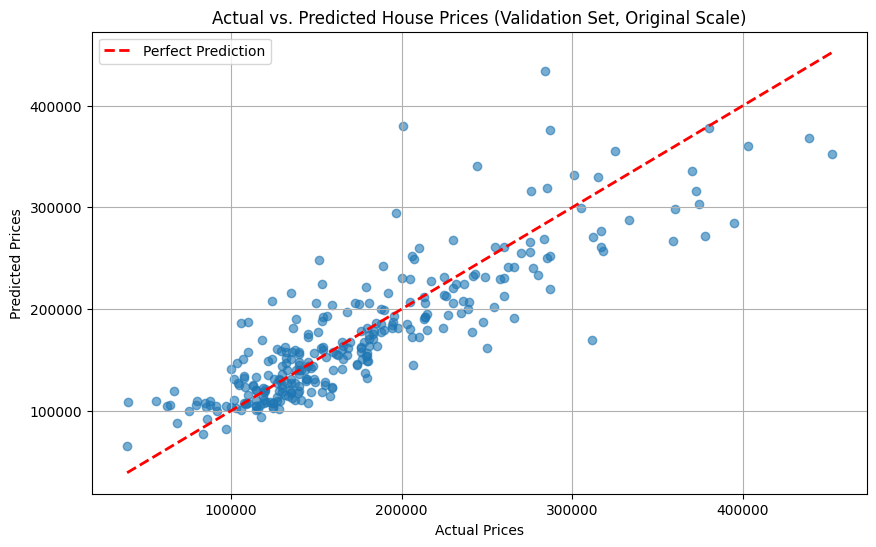

In [15]:
# Visualization of Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_val_original, y_pred_val_original, alpha=0.6)
min_val = min(y_val_original.min(), y_pred_val_original.min())
max_val = max(y_val_original.max(), y_pred_val_original.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
plt.title('Actual vs. Predicted House Prices (Validation Set, Original Scale)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)
plt.legend()
plt.show()

In [16]:
user_sq_ft = 2050
user_bedrooms = 2
user_total_bath = 2

# Print header
print("\n" + "="*50)
print("--- Predict House Price based on your input ---")
print("="*50)

# Create a DataFrame for the user's input, matching the expected model features
user_input_data = pd.DataFrame([[user_sq_ft, user_bedrooms, user_total_bath]],
                               columns=MODEL_FEATURES)

# Scale the user input using the SAME scaler fitted on the training data
user_input_scaled = scaler.transform(user_input_data)
user_input_scaled_df = pd.DataFrame(user_input_scaled, columns=MODEL_FEATURES)

# Make the prediction (output will be in log scale if log-transformed training was used)
predicted_price_log = model.predict(user_input_scaled_df)

# Transform the prediction back to the original price scale
predicted_price = np.expm1(predicted_price_log)[0]

# Display results
print(f"\n--- Your Input ---")
print(f"  Total Square Footage: {user_sq_ft:,}")
print(f"  Bedrooms: {user_bedrooms}")
print(f"  Total Bathrooms: {user_total_bath}")
print(f"\n--- Predicted Price ---")
print(f"The predicted house price is: ${predicted_price:,.2f}")



--- Predict House Price based on your input ---

--- Your Input ---
  Total Square Footage: 2,050
  Bedrooms: 2
  Total Bathrooms: 2

--- Predicted Price ---
The predicted house price is: $123,133.70
